In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from astropy.table import Table, join
from astropy.coordinates import SkyCoord, Galactic
from scipy.stats import binned_statistic
import matplotlib.lines as mlines

In [2]:
# Set the default font size for all text in the plot
plt.rcParams.update({'font.size': 18})

In [3]:
# Read a FITS table with a sub-set of Gaia measurements (parallax>2)
d = Table.read('https://people.ast.cam.ac.uk/~vasily/data/catalogues/gaia_dr3_nearby.fits', 
               format='fits')

In [4]:
# Reveal column names
d.columns

<TableColumns names=('ruwe','source_id','ra','dec','pmra','pmdec','pmra_error','pmdec_error','parallax','parallax_error','phot_g_mean_mag','bp_rp','phot_bp_rp_excess_factor','radial_velocity','radial_velocity_error','ebv','mh','teff','logg','allwise_w1','allwise_w2','r_med_photogeo','r_med_geo')>

In [5]:
# Create a SkyCoord object
coords = SkyCoord(ra=d['ra'], dec=d['dec'], unit="deg", frame="icrs")
gal_coords = coords.galactic

# Set some columns aside
l = gal_coords.l.deg
b = gal_coords.b.deg
rv = d['radial_velocity']
dist = d['r_med_photogeo']

In [8]:
# Selection cuts
# well-behaved star
wruwe = d['ruwe'] <1.4
# Distance in pc cut
wdist = dist < 500
# Low Galactic latitude
wb = np.abs(b) < 20
# Metallicity cuts
wmhlow = d['mh'] < -0.1
wmhhigh = d['mh'] > -0.1

# Combine
w = wruwe & wdist & wb
wrich = w & wmhhigh
wpoor = w & wmhlow

print(np.sum(w))

31552


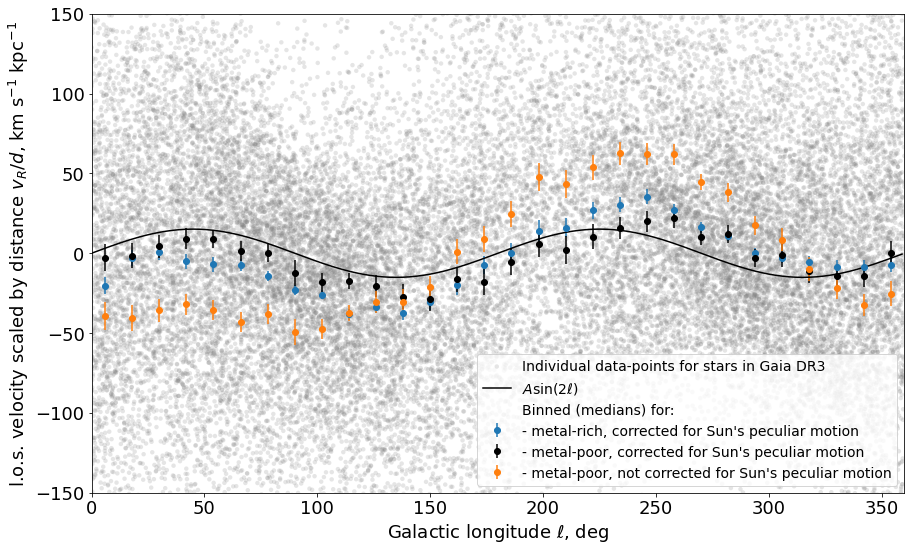

In [48]:
# Set A 
Oort_A = 15.1

# Binning parameters
lr = np.array([0, 360])
vrr = (-150, 150)
N = 30  # Number of bins

# With correction for Solar peculiar motion
rv_corr = rv+11.1*np.cos(np.radians(l))+13.2*np.sin(np.radians(l))

# Bin the data and compute medians using binned_statistic
bin_edges = np.linspace(lr[0], lr[1], N + 1)
lbins = 0.5 * (bin_edges[1:] + bin_edges[:-1])
med_rv_poor, _, _ = binned_statistic(l[wpoor], (1e+3*rv/dist)[wpoor], 
                                     statistic='median', bins=bin_edges)

med_rv_poor_corr, _, _ = binned_statistic(l[wpoor], (1e+3*rv_corr/dist)[wpoor], 
                                     statistic='median', bins=bin_edges)

med_rv_rich_corr, _, _ = binned_statistic(l[wrich], (1e+3*rv_corr/dist)[wrich], 
                                     statistic='median', bins=bin_edges)

# Compute the uncertainty of the median y using a lambda function
rv_poor_err, _, _ = binned_statistic(
    l[wpoor], (1e+3*rv/dist)[wpoor], statistic=lambda values: 1.253 * np.std(values) / np.sqrt(len(values)) 
    if len(values) > 1 else 0, bins=bin_edges)

rv_poor_corr_err, _, _ = binned_statistic(
    l[wpoor], (1e+3*rv_corr/dist)[wpoor], statistic=lambda values: 1.253 * np.std(values) / np.sqrt(len(values)) 
    if len(values) > 1 else 0, bins=bin_edges)

rv_rich_corr_err, _, _ = binned_statistic(
    l[wrich], (1e+3*rv_corr/dist)[wrich], statistic=lambda values: 1.253 * np.std(values) / np.sqrt(len(values)) 
    if len(values) > 1 else 0, bins=bin_edges)


fig, ax = plt.subplots(figsize=(13, 8))

unbinned = ax.scatter(l[w], 1000*(rv_corr/dist)[w], alpha=0.2, color='grey', edgecolors='none', s=20, 
           label='Individual data-points for stars in Gaia DR3')
binned1 = ax.errorbar(lbins, med_rv_rich_corr, yerr=rv_rich_corr_err, fmt='o', color='tab:blue', 
            label="- metal-rich, corrected for Sun's peculiar motion")
binned2 = ax.errorbar(lbins, med_rv_poor_corr, yerr=rv_poor_corr_err, fmt='o', color='black', 
           label="- metal-poor, corrected for Sun's peculiar motion")
binned3 = ax.errorbar(lbins, med_rv_poor, yerr=rv_poor_err, fmt='o', color='tab:orange',
           label="- metal-poor, not corrected for Sun's peculiar motion")

# Sin 2l 
ls = np.arange(0, 360, 1)
wave, = ax.plot(ls, Oort_A*np.sin(np.radians(2 * ls)), color='black', label = "$A\sin(2\ell)$")

# Create a dummy handle for the group heading
heading = mlines.Line2D([], [], color='none', label='Binned (medians) for:')

# Add the legend with the heading and grouped labels
ax.legend(handles=[unbinned, wave, heading, binned1, binned2, binned3], loc='lower right', fontsize=14)

ax.set_xlim(0,360)
ax.set_ylim(vrr)

ax.set_xlabel('Galactic longitude $\ell$, deg')
ax.set_ylabel('l.o.s. velocity scaled by distance $v_R/d$, km s$^{-1}$ kpc$^{-1}$')

# Adjust layout for better visibility and spacing
plt.tight_layout()

plt.savefig("../Figures/oort_constants_gaia.png", format="png", 
            dpi=300, transparent=False, facecolor='white', bbox_inches='tight')


plt.show()
